# Appartment's price using dvf database

In [1]:
!pip install econtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 KB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import KDTree

In [3]:
import econtools.metrics as mt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/ValeursFoncieresActualiseesAnciens.csv", sep =',')

<ipython-input-5-2fbca585628c>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/ValeursFoncieresActualiseesAnciens.csv", sep =',')


## Data processing

In [6]:
print("General information on the DataFrame")
data.info(verbose = True)

General information on the DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773715 entries, 0 to 4773714
Data columns (total 12 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id_mutation                object 
 1   valeur_fonciere            float64
 2   date_mutation              object 
 3   surface_reelle_bati        float64
 4   surface_terrain            float64
 5   longitude                  float64
 6   latitude                   float64
 7   code_type_local            float64
 8   nombre_pieces_principales  float64
 9   code_postal                float64
 10  code_commune               object 
 11  count_date                 int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 437.0+ MB


#### Missing values

In [7]:
percentage_missing_values = (data.isnull().mean()*100)
print("Percentage of missing data ")
percentage_missing_values

Percentage of missing data 


id_mutation                  0.000000
valeur_fonciere              0.079561
date_mutation                0.000000
surface_reelle_bati          0.000000
surface_terrain              0.000000
longitude                    1.205958
latitude                     1.205958
code_type_local              0.000000
nombre_pieces_principales    0.000000
code_postal                  0.004483
code_commune                 0.000000
count_date                   0.000000
dtype: float64

#### Search and delete duplicates. we also deleted the observations with missing values in the variables land_value, longitude and latitude. This choice is justified by the low percentage of missing values for these variables.

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data = data.dropna(subset=['valeur_fonciere','longitude', 'latitude'])

#### Delete sales under 10000 euros

In [10]:
filtre = data.valeur_fonciere < 10000
data = data.drop(data[filtre].index, axis = 0)

#### Eliminate flats of less than 9 m²

In [11]:
filtre = data.surface_reelle_bati < 9
data = data.drop(data[filtre].index, axis = 0)

###  type correction

In [12]:
cols_to_int = ['nombre_pieces_principales', 'code_commune',
               'code_type_local', 'code_postal', 
               'valeur_fonciere'
               ]
def to_int(data, cols):
    for col in cols:
        data[col] = data[col].astype('Int64', errors="ignore")
    return data
valeurs_foncieres = to_int(data, cols_to_int)

data.date_mutation = pd.to_datetime(data.date_mutation)

### General featuring
We decide to create three new variables. One that indicates the quarter and the year, it will be a categorical variable, which considers the number of quarters since the oldest date in the database and indicates in which quarter the transfer took place, considering the first quarter as the oldest date. Another that is interested the department. The third is the price per square meter


In [13]:
# department new variable
data["department"]= [str(code)[:2] if len(str(code))==5 else '0'+str(code)[:1] for code in data.code_commune]

In [14]:
# temporal aspect
begin_date = min(data.date_mutation)

data["yearquater"] = [((date.year - begin_date.year) * 4) + ((date.month - 1) // 3 - (begin_date.month - 1) // 3) + 1 for date in data.date_mutation]

In [15]:
# price per square meter

data["price"] = data["valeur_fonciere"] / data["surface_reelle_bati"]


## Working on apartement

In [16]:
data_apt = data[(data['code_type_local']==2)]

In [17]:
def avg_price_10NN(data):
  # Creation of a new column for the average price of the 10 closest properties geographically
  data["avg_price_10NN"] = np.nan

  # Convert the input data to a numpy array
  data_arr = data.values
    
  # Loop on each department to calculate the average price of the 10 closest properties geographically
  for dept in np.unique(data_arr[:, 0]):
    # Extraction of data for a given department
    data_dept = data_arr[data_arr[:, 0] == dept]
        
    # Building the kd-tree for the department
    tree = KDTree(data_dept[:, 1:3], leaf_size=10)
        
    # Find the 10 nearest neighbors for each observation in the department
    distances, indices = tree.query(data_dept[:, 1:3], k=11)
        
    # Calculate the average price of the 10 closest properties geographically for each observation
    avg_prices = np.mean(data_dept[indices[:, 1:], 3], axis=1)
        
    # Update the "average_10_nearest_price" column for the current department
    data_arr[data_arr[:, 0] == dept, 4] = avg_prices
    
    
  return data_arr


In [18]:
data_np = data_apt[['department','latitude','longitude','price']]
dat = avg_price_10NN(data_np)
data_apt['avg_price_10NN'] = dat[:,4].astype(float)

<ipython-input-17-950d322f176b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["avg_price_10NN"] = np.nan
<ipython-input-18-49a4e4e5a222>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_apt['avg_price_10NN'] = dat[:,4].astype(float)


In [19]:
del dat
del data_np

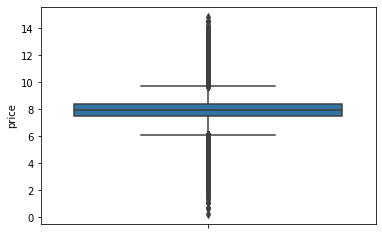

In [20]:
# boxplot price 
import matplotlib.pyplot as plt
sns.boxplot( y= np.log(data_apt['price']));
plt.show()

Let's remove outliers

In [21]:
def remove_outliers(df):
  q3 = df['price'].quantile(0.75)
  q1 = df['price'].quantile(0.25)
  IQR = q3 - q1
  return df[df['price'].between(q1 ,q3 + 1.5*IQR)]

Now we choose only the department of the 10 largest cities

In [22]:
#{'Paris':'75','Lyon':'69','Lille':'59','Bordeaux':'33','Marseille':'13','Toulouse':'31','Nantes':'44','Montpellier':'34','Strasbourg':'67', 'Nice':'06'}
top_10 = ('75','69','59','33','13','31','44','34','67','06')

In [23]:
def get_city(data):
  df = remove_outliers(data[data['department'].isin(top_10)]) 
  return df

In [24]:
new_set = get_city(data_apt)

Now let's split the data using the date to form the training and validation sets.

In [25]:
# Sorting of the data frame by ascending order of the transfer date
df = new_set.sort_values('date_mutation')
df['log_price'] = np.log(df['price'])
df['log_avg_price_10NN'] = np.log(df['avg_price_10NN'])
split = 0.8
X = df[['surface_reelle_bati', 'nombre_pieces_principales','log_avg_price_10NN']]
y = df[['log_price','price']]

In [26]:
n = math.ceil(split*len(y))
X_train, X_test = X.iloc[:n], X.iloc[n:-1]
y_train, y_test =  y[:n], y[n:-1]

### OLS

In [27]:
train = df[['log_price','surface_reelle_bati', 'nombre_pieces_principales','log_avg_price_10NN','price']].iloc[:n]
test = df[['log_price','surface_reelle_bati', 'nombre_pieces_principales','log_avg_price_10NN','price']].iloc[n:-1]

In [28]:
lin_reg = mt.reg(train,'log_price',['surface_reelle_bati', 'nombre_pieces_principales','log_avg_price_10NN'],vce_type='robust',addcons=False)
#test['_cons'] = [1 for i in range(len(test))]
features = ['surface_reelle_bati', 'nombre_pieces_principales','log_avg_price_10NN']
test['prediction'] = [sum([lin_reg.beta[f]*(test[f].iloc[i]) for f in features]) for i in range(len(test))]
np.mean(np.abs((np.exp(test['prediction'])-test['price'])/test['price']))

0.19442965715407026

### Random forest 

In [31]:
rf = RandomForestRegressor(n_estimators=100,max_depth=6)

rf.fit(X_train,y_train['log_price'])

y_pred = rf.predict(X_test)

In [33]:
rsquared = r2_score(y_test['price'],np.exp(y_pred))
print("R squared on test set: {:.4f}".format(rsquared))

R squared on test set: 0.7577


In [34]:
mae = mean_absolute_percentage_error(y_test['price'],np.exp(y_pred))
print(" mean absolute percentage error on test set: {:.4f}".format(mae))

 mean absolute percentage error on test set: 0.1627


### Gradient Boosting Regressor

In [35]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [36]:
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train['log_price'])

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [41]:
rsquared = reg.score(X_test,y_test['log_price'])
print("R squared on test set: {:.4f}".format(rsquared))

R squared on test set: 0.7518


In [40]:
mae = mean_absolute_percentage_error(y_test['price'],np.exp(reg.predict(X_test)))
print(" mean absolute percentage error on test set: {:.4f}".format(mae))

 mean absolute percentage error on test set: 0.1622
